In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = "C:\\Users\\Anthony\\Documents\\Data for Assingment 1 AMP466.xlsx"
df = pd.read_excel(DATA_PATH)

df["Maturity Date"] = pd.to_datetime(df["Maturity Date"])
df["Issue Date"] = pd.to_datetime(df["Issue Date"], errors="coerce")  # safe parse

# Date columns are the remaining columns after the bond descriptors
meta_cols = ["Bond#", "ISIN", "Coupon", "Issue Date", "Maturity Date"]
date_cols = [c for c in df.columns if c not in meta_cols]

In [4]:
SELECTED_ISINS = [
    "CA135087S547",  # 3% Feb 1 2027
    "CA135087H235",  # 2% Jun 1 2028
    "CA135087T958",  # 2.25% Febv 1 2028
    "CA135087L930",  # 1% Sep 1 2026
    "CA135087T388",  # 2.75% April 1 2030
    "CA135087S471",  # 2.75% Mar 1 2030
    "CA135087J397",  # 2.25% Jun 1 2029
    "CA135087S885",  # 2.75% May 1 2027
    "CA135087E679",  # 1.5% Jun 1 2026
    "CA135087N266",  # 1.50% Dec 1 2031
]

sub = df[df["ISIN"].isin(SELECTED_ISINS)].copy()
assert sub.shape[0] == 10, f"Expected 10 bonds, found {sub.shape[0]}"

In [5]:
FACE = 100.0
FREQ = 2  # semi-annual coupons (Govt of Canada convention)

def yearfrac_act36525(start, end):
    """Actual/365.25 year fraction."""
    return (end - start).days / 365.25

def price_from_ytm_cont(y, coupon_rate_annual, T_years, face=FACE, freq=FREQ):
    """
    Price a coupon bond using a single YTM y (continuous compounding).
    Simplified cashflow schedule: payments at times k/freq for k=1..n,
    where n = round(T_years * freq).
    """
    if T_years <= 0:
        return np.nan

    n = int(round(T_years * freq))
    n = max(n, 1)

    times = np.arange(1, n + 1) / freq
    C = face * coupon_rate_annual / freq  # semi-annual coupon payment

    cfs = np.full(n, C)
    cfs[-1] += face  # add principal at maturity

    return np.sum(cfs * np.exp(-y * times))

In [6]:
def solve_ytm_bisection_cont(price, coupon_rate_annual, T_years, lo=-0.05, hi=0.20, tol=1e-12, max_iter=300):
    """Solve for y via robust bisection with auto-bracketing."""
    if not np.isfinite(price) or T_years <= 0:
        return np.nan

    def f(y):
        return price_from_ytm_cont(y, coupon_rate_annual, T_years) - price

    flo, fhi = f(lo), f(hi)

    for _ in range(30):
        if flo * fhi <= 0:
            break
        if flo > 0 and fhi > 0:
            hi += 0.20
        else:
            lo -= 0.20
        flo, fhi = f(lo), f(hi)

    if flo * fhi > 0:
        return np.nan  # can't bracket root

    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        fmid = f(mid)
        if abs(fmid) < tol or (hi - lo) < tol:
            return mid
        if flo * fmid <= 0:
            hi, fhi = mid, fmid
        else:
            lo, flo = mid, fmid

    return 0.5 * (lo + hi)

In [8]:
# Identify date columns (your notebook already does this, but keep it robust)
meta_cols = ["Bond#", "ISIN", "Coupon", "Issue Date", "Maturity Date"]
date_cols = [c for c in df.columns if c not in meta_cols]

# Ensure our sub is sorted by maturity (helps debugging)
sub = sub.sort_values("Maturity Date").reset_index(drop=True)

ytm_rows = []

for dcol in date_cols:
    day = pd.to_datetime(dcol)

    T = sub["Maturity Date"].apply(lambda md: yearfrac_act36525(day, md)).to_numpy()
    P = sub[dcol].astype(float).to_numpy()
    cpn = sub["Coupon"].astype(float).to_numpy()

    y = np.array([solve_ytm_bisection_cont(p, c, t) for p, c, t in zip(P, cpn, T)])

    tmp = pd.DataFrame({
        "Date": day.date(),
        "ISIN": sub["ISIN"].values,
        "Maturity": sub["Maturity Date"].dt.date.values,
        "TTM_years": T,
        "Coupon": cpn,
        "Price": P,
        "YTM_cont": y
    })
    ytm_rows.append(tmp)

ytm_table = pd.concat(ytm_rows, ignore_index=True)
ytm_table.head(10)


,Date,ISIN,Maturity,TTM_years,Coupon,Price,YTM_cont
0,2026-01-05,CA135087E679,2026-06-01,0.402464,0.0150,99.680,0.021354
1,2026-01-05,CA135087L930,2026-09-01,0.654346,0.0100,99.145,0.027149
2,2026-01-05,CA135087S547,2027-02-01,1.073238,0.0300,100.545,0.024302
3,2026-01-05,CA135087S885,2027-05-01,1.316906,0.0275,100.325,0.025120
4,2026-01-05,CA135087T958,2028-02-01,2.072553,0.0225,99.239,0.026258
5,2026-01-05,CA135087H235,2028-06-01,2.403833,0.0200,98.550,0.025860
6,2026-01-05,CA135087J397,2029-06-01,3.403149,0.0225,98.270,0.027530
7,2026-01-05,CA135087S471,2030-03-01,4.150582,0.0275,99.493,0.028645
8,2026-01-05,CA135087T388,2030-09-01,4.654346,0.0275,99.165,0.029280
9,2026-01-05,CA135087N266,2031-12-01,5.902806,0.0150,91.310,0.030745


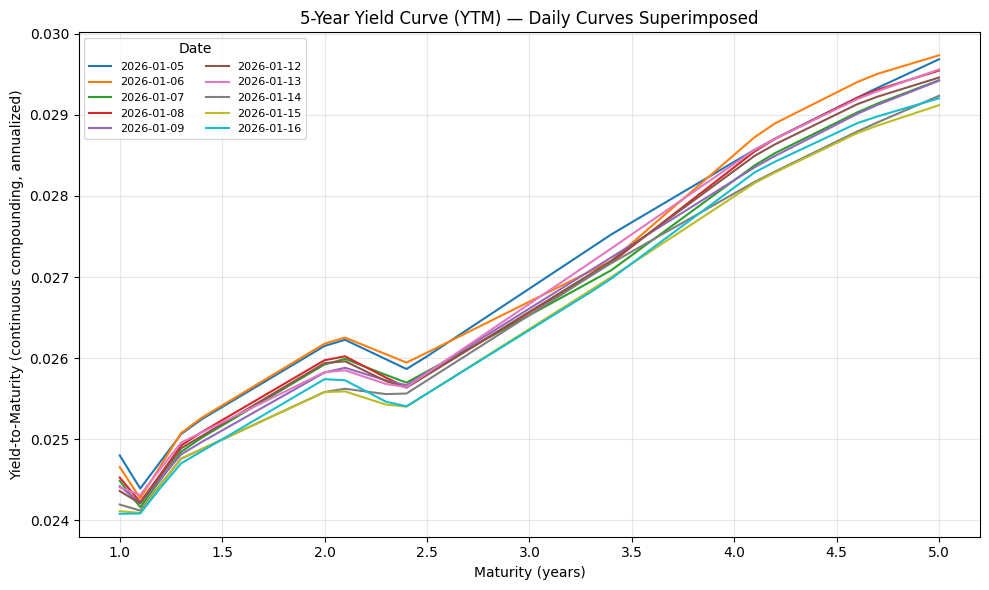

In [7]:
grid = np.linspace(1.0, 5.0, 41)  # 1Y–5Y grid (avoids extrapolating below available maturities)

plt.figure(figsize=(10, 6))

for dcol in date_cols:
    day = pd.to_datetime(dcol)

    # Time-to-maturity as of this specific day
    T = sub["Maturity Date"].apply(lambda md: yearfrac_act36525(day, md)).to_numpy()

    prices = sub[dcol].astype(float).to_numpy()
    coupons = sub["Coupon"].astype(float).to_numpy()  # decimal form (e.g., 0.0275)

    ytms = np.array([
        solve_ytm_bisection_cont(p, c, t)
        for p, c, t in zip(prices, coupons, T)
    ])

    # Keep valid points
    mask = np.isfinite(ytms) & np.isfinite(T) & (T > 0) & (T < 10)
    T_use = T[mask]
    y_use = ytms[mask]

    # sort by maturity
    idx = np.argsort(T_use)
    T_use = T_use[idx]
    y_use = y_use[idx]

    # Linear interpolation onto the 1–5Y grid
    y_grid = np.interp(grid, T_use, y_use, left=np.nan, right=np.nan)

    plt.plot(grid, y_grid, linewidth=1.5, label=str(day.date()))

plt.title("5-Year Yield Curve (YTM) — Daily Curves Superimposed")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield-to-Maturity (continuous compounding, annualized)")
plt.grid(True, alpha=0.3)
plt.legend(title="Date", fontsize=8, ncols=2)
plt.tight_layout()
plt.show()

## Template Bootstrap Function

In [46]:
def bootstrap_yield_curve(bonds):
    spot_rates = np.zeros(len(bonds))

    for i, (price, coupon_rate, maturity) in enumerate(sorted(bonds, key=lambda x: x[2])):
        cash_flows = np.array([coupon_rate] * int(maturity - 1) + [100 + coupon_rate])
        time_periods = np.arange(1, maturity + 1)
        # Use previously calculated spot rates for discounted cash flows
        if i == 0:
            discounted_cash_flows = cash_flows / (1 + spot_rates[i])**time_periods
        else:
            discounted_cash_flows = [cf / (1 + spot_rates[j])**time_periods[j] for j, cf in enumerate(cash_flows)]
            discounted_cash_flows = np.sum(discounted_cash_flows)

        residual = price - discounted_cash_flows
        if residual <= 0:
            # Handle cases where residual is too low
            print(f"Warning: Residual for bond with maturity {maturity} is too low. Adjusting spot rate calculation.")
            spot_rate = spot_rates[i-1]  # Use previous spot rate as an approximation
        else:
            spot_rate = ((100 / residual)**(1 / maturity)) - 1
        spot_rates[i] = spot_rate

    return spot_rates

In [48]:
FACE = 100.0
FREQ = 2  # semiannual

def yearfrac_act36525(start, end):
    return (end - start).days / 365.25

def build_cashflows_semiannual(coupon_rate_annual, T_years, face=FACE, freq=FREQ):
    """
    Simplified schedule: payments every 0.5y up to T rounded to nearest 0.5y.
    Returns times t_k and cashflows p_k.
    """
    n = int(round(T_years * freq))
    n = max(n, 1)
    times = np.arange(1, n + 1) / freq
    coupon_payment = face * coupon_rate_annual / freq
    cfs = np.full(n, coupon_payment)
    cfs[-1] += face
    return times, cfs

def bootstrap_spot_curve_continuous(sub, day_col):
    """
    Bootstraps spot rates r(t) with continuous compounding:
      PV(cf at t) = cf * exp(-r(t)*t)
    Returns arrays (times, spot_rates) for all bootstrapped times.
    """
    day = pd.to_datetime(day_col)

    # time to maturity and observed prices
    T = sub["Maturity Date"].apply(lambda md: yearfrac_act36525(day, md)).to_numpy()
    P = sub[day_col].astype(float).to_numpy()
    cpn = sub["Coupon"].astype(float).to_numpy()

    # sort by maturity
    idx = np.argsort(T)
    T, P, cpn = T[idx], P[idx], cpn[idx]

    # store discount factors D(t)=exp(-r(t)*t)
    D = {}  # key: time t, value: D(t)

    for Tj, Pj, cj in zip(T, P, cpn):
        times, cfs = build_cashflows_semiannual(cj, Tj)

        # PV of known earlier cashflows
        pv_known = 0.0
        for t_k, cf_k in zip(times[:-1], cfs[:-1]):
            if t_k in D:
                pv_known += cf_k * D[t_k]
            else:
                # if missing earlier time, skip (or handle via interpolation if needed)
                pass

        t_last = times[-1]
        cf_last = cfs[-1]

        residual = Pj - pv_known
        if residual <= 0 or not np.isfinite(residual):
            D[t_last] = np.nan
        else:
            # residual = cf_last * exp(-r(t_last)*t_last) => D(t_last)=residual/cf_last
            D[t_last] = residual / cf_last

    # convert discount factors to spot rates
    times_all = np.array(sorted(D.keys()))
    D_all = np.array([D[t] for t in times_all])

    spot_all = np.full_like(times_all, np.nan, dtype=float)
    mask = np.isfinite(D_all) & (D_all > 0) & (times_all > 0)
    spot_all[mask] = -np.log(D_all[mask]) / times_all[mask]

    return times_all, spot_all

def plot_daily_spot_curves(sub, date_cols):
    grid = np.linspace(1.0, 5.0, 41)
    plt.figure(figsize=(10, 6))

    for dcol in date_cols:
        t_pts, r_pts = bootstrap_spot_curve_continuous(sub, dcol)

        # restrict to 1–5y for plotting
        mask = np.isfinite(r_pts) & (t_pts >= 1.0) & (t_pts <= 5.0)
        t_use, r_use = t_pts[mask], r_pts[mask]

        if len(t_use) < 2:
            continue

        idx = np.argsort(t_use)
        t_use, r_use = t_use[idx], r_use[idx]

        # piecewise linear interpolation across maturity
        r_grid = np.interp(grid, t_use, r_use, left=np.nan, right=np.nan)
        plt.plot(grid, r_grid, linewidth=1.6, label=str(pd.to_datetime(dcol).date()))

    plt.title("5-Year Spot Curve (Bootstrapped) — Daily Curves Superimposed")
    plt.xlabel("Maturity (years)")
    plt.ylabel("Spot rate (continuous compounding, annualized)")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Date", fontsize=8, ncols=2)
    plt.tight_layout()
    plt.show()


In [ ]:
#Arbitrage Check
test_day = date_cols[0]
times, spot_rates = bootstrap_spot_curve_continuous(sub, test_day)

D = np.exp(-spot_rates * times)

mask = np.isfinite(D)
np.all(np.diff(D[mask]) < 0)


np.True_

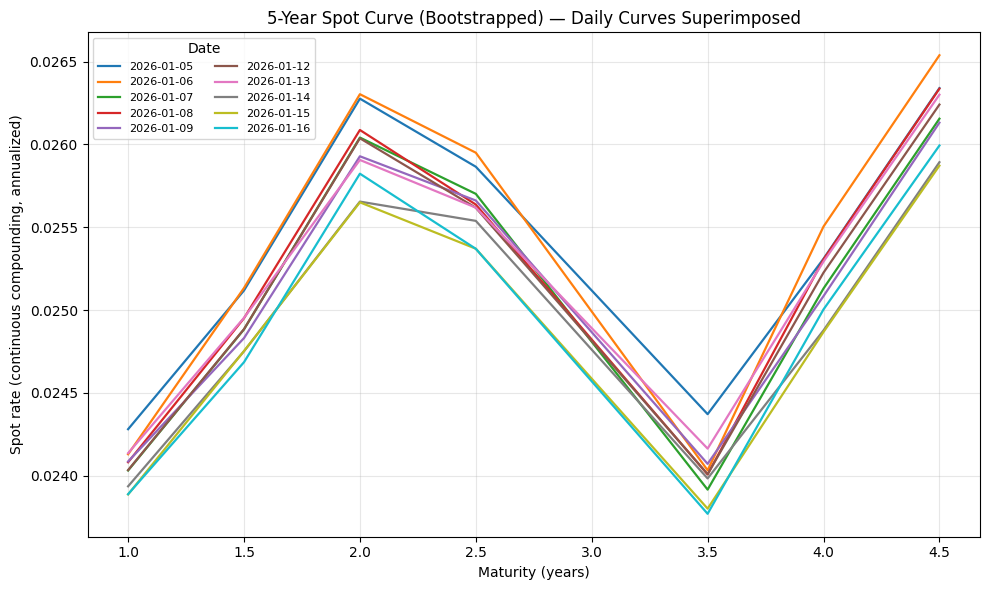

In [49]:
plot_daily_spot_curves(sub, date_cols)

In [38]:
def forward_curve_from_spot(times, spots, grid):
    """
    Build forward rates on [1,5] using continuous compounding:
      f(T_i,T_{i+1}) = (r_{i+1} T_{i+1} - r_i T_i) / (T_{i+1} - T_i)
    We first interpolate the spot curve onto 'grid', then compute finite-difference forwards.
    Returns:
      midpoints, forward_rates
    """
    # restrict to finite points
    mask = np.isfinite(times) & np.isfinite(spots)
    times = times[mask]
    spots = spots[mask]

    # sort
    idx = np.argsort(times)
    times, spots = times[idx], spots[idx]

    # interpolate spot curve onto the grid (no extrapolation)
    r_grid = np.interp(grid, times, spots, left=np.nan, right=np.nan)

    # compute forward rates between consecutive grid points
    T1 = grid[:-1]
    T2 = grid[1:]
    r1 = r_grid[:-1]
    r2 = r_grid[1:]

    # forward is defined only where both endpoints exist
    ok = np.isfinite(r1) & np.isfinite(r2)
    f = np.full_like(T1, np.nan, dtype=float)
    f[ok] = (r2[ok] * T2[ok] - r1[ok] * T1[ok]) / (T2[ok] - T1[ok])

    mid = 0.5 * (T1 + T2)
    return mid, f

def plot_daily_forward_curves(sub, date_cols):
    grid = np.linspace(1.0, 5.0, 41)  # same grid as earlier

    plt.figure(figsize=(10, 6))

    for dcol in date_cols:
        # bootstrapped spot points
        times, spots = bootstrap_spot_curve_continuous(sub, dcol)

        mid, f = forward_curve_from_spot(times, spots, grid)

        plt.plot(mid, f, linewidth=1.6, label=str(pd.to_datetime(dcol).date()))

    plt.title("5-Year Forward Rate Curve — Daily Curves Superimposed")
    plt.xlabel("Forward interval midpoint (years)")
    plt.ylabel("Forward rate (continuous compounding, annualized)")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Date", fontsize=8, ncols=2)
    plt.tight_layout()
    plt.show()

## Bootstrapping spot rates

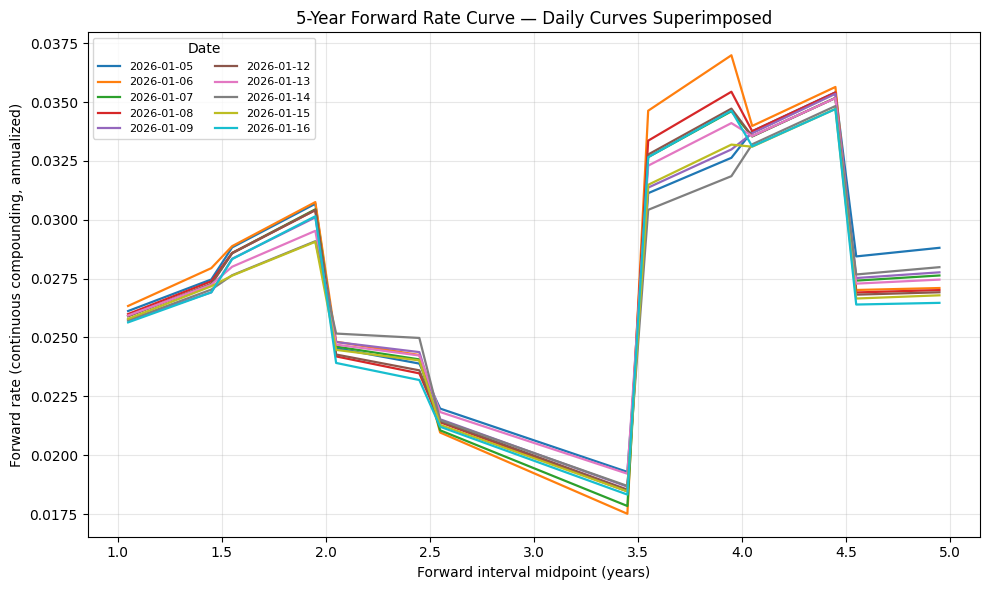

In [45]:
plot_daily_forward_curves(sub, date_cols)


In [ ]:
def log_returns(R):
    """
    R: array shape (num_days, num_vars), positive rates.
    returns: array shape (num_days-1, num_vars)
    """
    return np.log(R[1:, :] / R[:-1, :])

def cov_matrix_from_log_returns(R):
    """
    R: (num_days, num_vars) levels -> compute log returns then covariance across variables.
    """
    X = log_returns(R)              # (9, num_vars)
    return np.cov(X, rowvar=False, ddof=1)  # sample covariance


yield_tenors = np.array([1, 2, 3, 4, 5], dtype=float)

yields_by_day = []
for dcol in date_cols:
    day = pd.to_datetime(dcol)

    # time to maturity 
    Tbond = sub["Maturity Date"].apply(lambda md: (md - day).days / 365.25).to_numpy()
    Pbond = sub[dcol].astype(float).to_numpy()
    cbond = sub["Coupon"].astype(float).to_numpy()

    # compute 10 bond YTMs for this day
    ytm = np.array([solve_ytm_bisection_cont(p, c, t) for p, c, t in zip(Pbond, cbond, Tbond)])

    # interpolate bond YTMs to get r(1),...,r(5)
    mask = np.isfinite(ytm) & np.isfinite(Tbond) & (Tbond > 0)
    T_use, y_use = Tbond[mask], ytm[mask]
    idx = np.argsort(T_use)
    T_use, y_use = T_use[idx], y_use[idx]

    y_grid = np.interp(yield_tenors, T_use, y_use, left=np.nan, right=np.nan)
    yields_by_day.append(y_grid)

yields_by_day = np.array(yields_by_day)  # shape (10 days, 5)


# Intervals: (1,2), (1,3), (1,4), (1,5)
forward_labels = ["1y-1y", "1y-2y", "1y-3y", "1y-4y"]
forward_targets = [(1,2), (1,3), (1,4), (1,5)]

forwards_by_day = []
for dcol in date_cols:
    # bootstrap spot curve points for this day
    t_pts, r_pts = bootstrap_spot_curve_continuous(sub, dcol)

    mask = np.isfinite(t_pts) & np.isfinite(r_pts)
    t_pts, r_pts = t_pts[mask], r_pts[mask]
    idx = np.argsort(t_pts)
    t_pts, r_pts = t_pts[idx], r_pts[idx]

    r_at = np.interp([1,2,3,4,5], t_pts, r_pts, left=np.nan, right=np.nan)

    # forward rate
    # f(a,b) = (r(b)*b - r(a)*a) / (b-a)
    f_list = []
    for (a,b) in forward_targets:
        ra = r_at[a-1]
        rb = r_at[b-1]
        f_list.append((rb*b - ra*a)/(b-a) if np.isfinite(ra) and np.isfinite(rb) else np.nan)

    forwards_by_day.append(np.array(f_list))

forwards_by_day = np.array(forwards_by_day)  


cov_y = cov_matrix_from_log_returns(yields_by_day)      # 5x5
cov_f = cov_matrix_from_log_returns(forwards_by_day)    # 4x4

cov_y_df = pd.DataFrame(cov_y, index=[f"{int(t)}Y" for t in yield_tenors], columns=[f"{int(t)}Y" for t in yield_tenors])
cov_f_df = pd.DataFrame(cov_f, index=forward_labels, columns=forward_labels)

print("Covariance matrix (YIELD log-returns):")
display(cov_y_df)

print("Covariance matrix (FORWARD log-returns):")
display(cov_f_df)


Covariance matrix (YIELD log-returns):


,1Y,2Y,3Y,4Y,5Y
1Y,0.000013,0.000012,0.000011,0.000021,0.000018
2Y,0.000012,0.000034,0.000005,0.000036,0.000028
3Y,0.000011,0.000005,0.000015,0.000013,0.000014
4Y,0.000021,0.000036,0.000013,0.000049,0.000040
5Y,0.000018,0.000028,0.000014,0.000040,0.000034


Covariance matrix (FORWARD log-returns):


,1y-1y,1y-2y,1y-3y,1y-4y
1y-1y,0.000115,-0.000002,0.000104,0.000048
1y-2y,-0.000002,0.000019,0.000012,0.000017
1y-3y,0.000104,0.000012,0.000144,0.000080
1y-4y,0.000048,0.000017,0.000080,0.000051



LaTeX (yield covariance):
\begin{pmatrix}
1.33854344e-05 & 1.18476558e-05 & 1.10020659e-05 & 2.06040430e-05 & 1.79506822e-05 \\
1.18476558e-05 & 3.44147021e-05 & 4.71066198e-06 & 3.62104872e-05 & 2.78856611e-05 \\
1.10020659e-05 & 4.71066198e-06 & 1.54940546e-05 & 1.29016180e-05 & 1.37345985e-05 \\
2.06040430e-05 & 3.62104872e-05 & 1.29016180e-05 & 4.90742511e-05 & 4.02716591e-05 \\
1.79506822e-05 & 2.78856611e-05 & 1.37345985e-05 & 4.02716591e-05 & 3.43944852e-05 \\
\end{pmatrix}

LaTeX (forward covariance):
\begin{pmatrix}
1.14963355e-04 & -2.19527181e-06 & 1.04345079e-04 & 4.80582856e-05 \\
-2.19527181e-06 & 1.92595277e-05 & 1.22705738e-05 & 1.71480798e-05 \\
1.04345079e-04 & 1.22705738e-05 & 1.44449417e-04 & 7.95158649e-05 \\
4.80582856e-05 & 1.71480798e-05 & 7.95158649e-05 & 5.09503475e-05 \\
\end{pmatrix}


In [57]:
ov_y = cov_y_df.values

eigvals_y, eigvecs_y = np.linalg.eigh(cov_y)

# sort descending
idx_y = np.argsort(eigvals_y)[::-1]
eigvals_y = eigvals_y[idx_y]
eigvecs_y = eigvecs_y[:, idx_y]

print("YIELD covariance eigenvalues:")
print(eigvals_y)

print("\nYIELD covariance eigenvectors (columns correspond to eigenvalues):")
print(eigvecs_y)


# ---------- Forward covariance ----------
cov_f = cov_f_df.values

eigvals_f, eigvecs_f = np.linalg.eigh(cov_f)

# sort descending
idx_f = np.argsort(eigvals_f)[::-1]
eigvals_f = eigvals_f[idx_f]
eigvecs_f = eigvecs_f[:, idx_f]

print("\nFORWARD covariance eigenvalues:")
print(eigvals_f)

print("\nFORWARD covariance eigenvectors (columns correspond to eigenvalues):")
print(eigvecs_f)

YIELD covariance eigenvalues:
[1.22551595e-04 1.87900396e-05 3.38237812e-06 1.89080029e-06
 1.48114551e-07]

YIELD covariance eigenvectors (columns correspond to eigenvalues):
[[-0.27467773 -0.38195513  0.10356388 -0.84620935  0.22774258]
 [-0.47028238  0.55574795 -0.65814076 -0.1448683   0.12586747]
 [-0.19154074 -0.72074416 -0.57155256  0.2565655  -0.22658732]
 [-0.62825676  0.08421351  0.38468608  0.03262945 -0.67018912]
 [-0.52152873 -0.13671297  0.28542872  0.44277802  0.65711142]]

FORWARD covariance eigenvalues:
[2.73778517e-04 4.35504809e-05 1.16968882e-05 5.96760922e-07]

FORWARD covariance eigenvectors (columns correspond to eigenvalues):
[[-0.58393263  0.6621902  -0.46331718  0.07657686]
 [-0.05523745 -0.52151675 -0.74414411 -0.41378575]
 [-0.71280456 -0.24307711  0.4758711  -0.45427951]
 [-0.38455321 -0.48003951 -0.07164796  0.78520536]]


In [59]:
A = cov_y_df.values
w, V = np.linalg.eigh(A)
idx = np.argsort(w)[::-1]
w, V = w[idx], V[:,idx]

A_recon = V @ np.diag(w) @ V.T
print("max abs recon error:", np.max(np.abs(A - A_recon)))


print("max abs(V^T V - I):", np.max(np.abs(V.T @ V - np.eye(V.shape[1]))))


max abs recon error: 3.3881317890172014e-20
max abs(V^T V - I): 6.661338147750939e-16
